# Dependencies

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessinsg import OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import classification_report

In [17]:
from sklearn.feature_selection import VarianceThreshold
from varclushi import VarClusHi
from optbinning import BinningProcess

In [18]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from joblib import dump
from joblib import load
from sklearn.model_selection import cross_val_score

In [19]:
import optuna
from sklearn.model_selection import StratifiedKFold

In [20]:
import fs
PROCESSED_PROJECT_DIR = fs.open_fs("../../data/processed/project")
X_TRAIN_DIR = PROCESSED_PROJECT_DIR.getsyspath("x_train.csv")
X_TEST_DIR = PROCESSED_PROJECT_DIR.getsyspath("x_test.csv")
X_VAL_DIR = PROCESSED_PROJECT_DIR.getsyspath("x_val.csv")
Y_TRAIN_DIR = PROCESSED_PROJECT_DIR.getsyspath("y_train.csv")
Y_TEST_DIR = PROCESSED_PROJECT_DIR.getsyspath("y_test.csv")
Y_VAL_DIR = PROCESSED_PROJECT_DIR.getsyspath("y_val.csv")

In [21]:
RAW_PROJECT_DIR = fs.open_fs("../../data/raw/project")
INTERIM_PROJECT_DIR = fs.open_fs("../../data/interim/project")
RAW_FILE_NAME = RAW_PROJECT_DIR.getsyspath("hmeq.csv")

# Reading

In [22]:
df = pd.read_csv(RAW_FILE_NAME)
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


/tmp/ipykernel_110619/1396573111.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=job_counts.values, y=job_counts.index, palette=bar_colors)


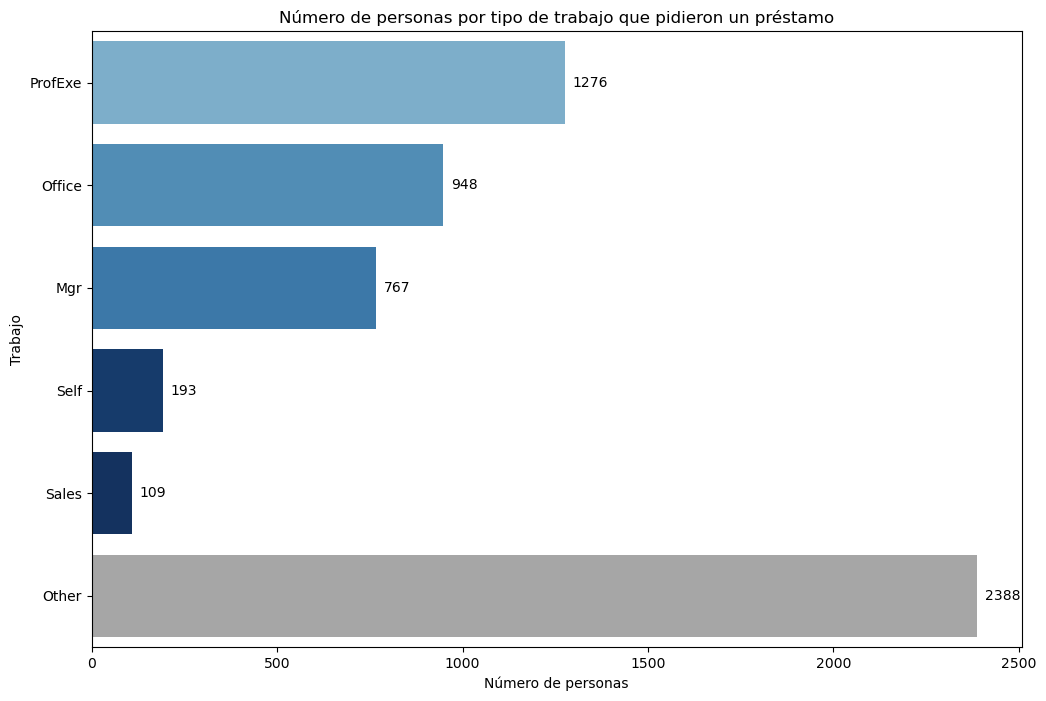

In [23]:
job_counts = df['JOB'].value_counts().sort_values(ascending=False)
job_counts = pd.concat([job_counts[job_counts.index != 'Other'], pd.Series({'Other': df['JOB'].value_counts()['Other']})])

norm = plt.Normalize(job_counts.min(), job_counts.max())
sm = plt.cm.ScalarMappable(cmap="Blues_r", norm=norm)
sm.set_array([])

bar_colors = ['#A6A6A6' if index == 'Other' else sm.to_rgba(value) for index, value in zip(job_counts.index, job_counts.values)]

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=job_counts.values, y=job_counts.index, palette=bar_colors)
plt.title('Número de personas por tipo de trabajo que pidieron un préstamo')
plt.xlabel('Número de personas')
plt.ylabel('Trabajo')

for i, v in enumerate(job_counts.values):
    ax.text(v + 20, i, str(v), color='black', va='center')

plt.show()

# Nulls [Conteo y borrado]

In [24]:
#Conteno de Datos nulos totales

null_count = df.isnull().sum().sum()
print('Number of null values:', null_count)

Number of null values: 5271


In [25]:
#Conteno de Datos nulos por categoria
df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [26]:
#Borra los datos nulos
df_clean = df.dropna()

In [27]:
#Comprobar que se borraran los datos nulos
df_clean.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [28]:
df_clean

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
7,1,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
19,0,2300,102370.0,120953.0,HomeImp,Office,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503
25,1,2400,34863.0,47471.0,HomeImp,Mgr,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601
26,0,2400,98449.0,117195.0,HomeImp,Office,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


# EDA

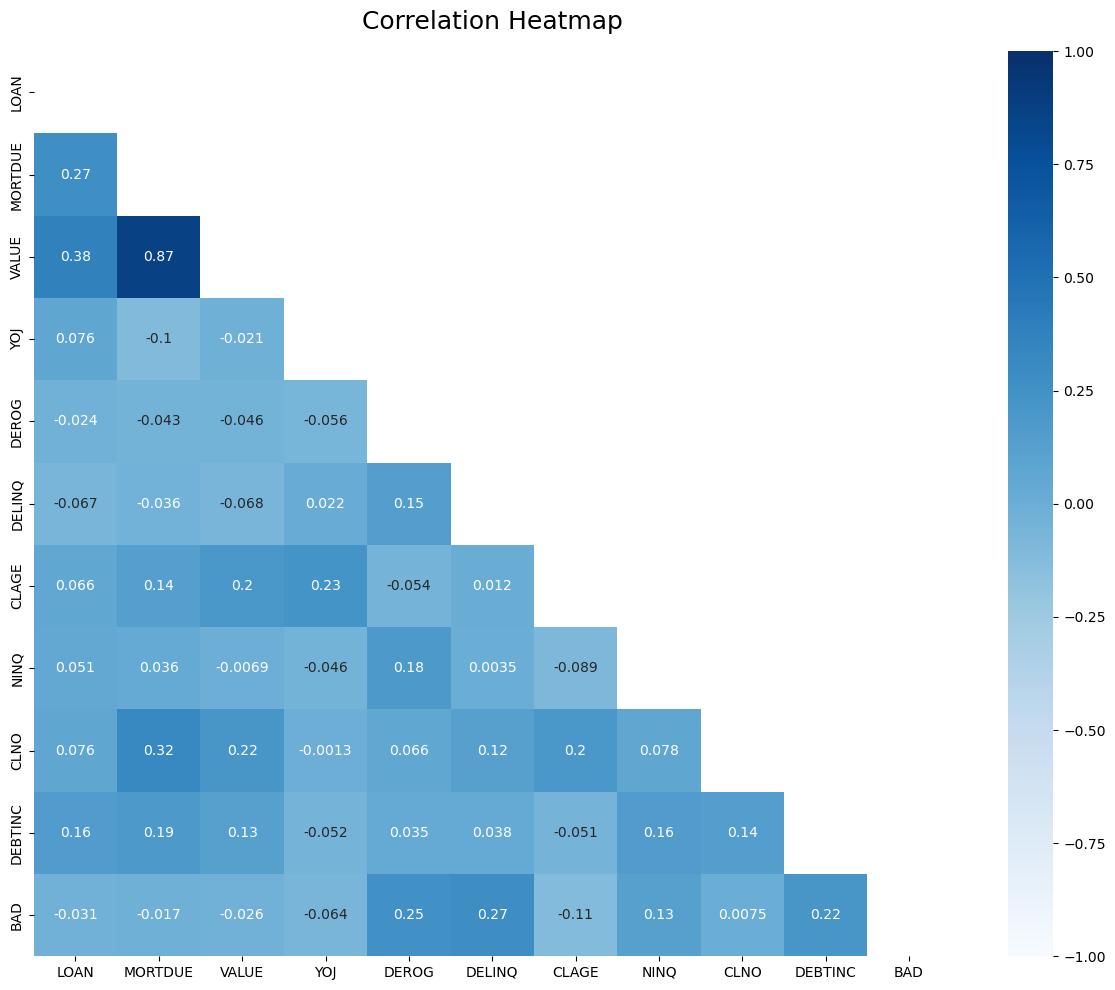

In [29]:
columns_of_interest = [
    'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ',
    'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'BAD'
]


correlation_matrix = df_clean[columns_of_interest].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='Blues', vmin=-1, vmax=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)

plt.tight_layout()
plt.show()


# Correlación con el monto pedido

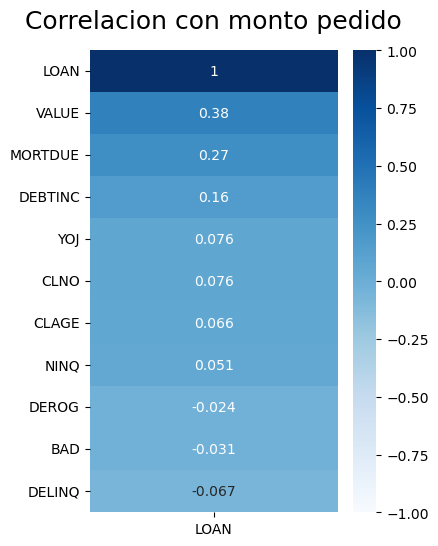

In [30]:
# Definir la variable de interés y las columnas numéricas
var_int = [
    'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ',
    'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'BAD'
]

# Crear el heatmap para la variable 'LOAN' con los datos limpios (df_clean)
plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(df_clean[var_int].corr()[['LOAN']].sort_values(by='LOAN', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlacion con monto pedido', fontdict={'fontsize': 18}, pad=16)
plt.show()


El monto del préstamo (LOAN) está más fuertemente correlacionado con el valor de la propiedad (VALUE) y la deuda hipotecaria existente (MORTDUE), lo que sugiere que aquellos con más activos y deuda preexistente tienden a solicitar montos de préstamos más altos.

 Por otro lado, variables relacionadas con el historial de crédito problemático, como DELINQ y DEROG, tienen correlaciones negativas o muy débiles, lo que indica que los prestatarios con más problemas crediticios probablemente tienen acceso a préstamos más pequeños o enfrentan dificultades para obtener préstamos.

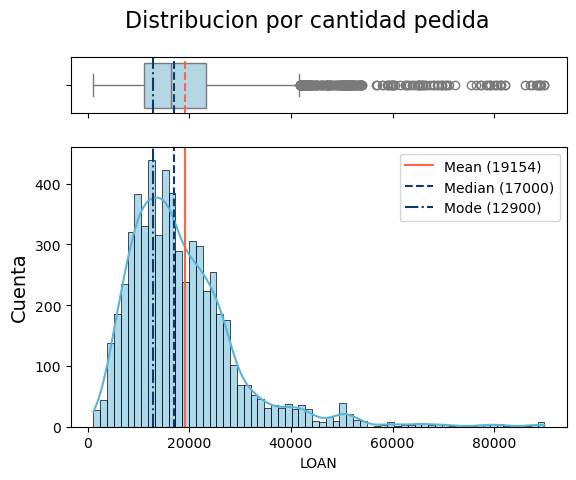

In [31]:
mean = df_clean['LOAN'].mean()
median = df_clean['LOAN'].median()
mode = df_clean['LOAN'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="LOAN", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="LOAN", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta', fontsize=14)

f.suptitle('Distribucion por cantidad pedida ', fontsize=16)
plt.show()

### Distribución del valor de la propiedad y Correlación con el monto pedido

In [32]:
from scipy.stats import pearsonr

# Suponiendo que tienes dos variables 'x' y 'y' en un DataFrame 'df'
corr, p_value = pearsonr(df_clean['VALUE'], df_clean['LOAN'])

print(f"Correlación de Pearson: {corr}")
print(f"Valor p: {p_value}")

Correlación de Pearson: 0.3787235201962146
Valor p: 3.408819187570339e-115


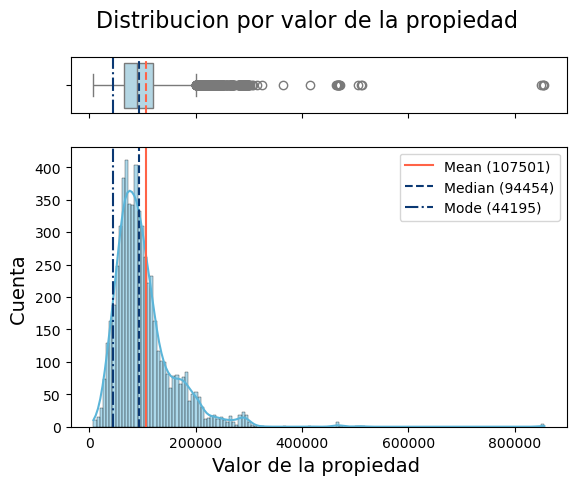

In [33]:
mean = df_clean['VALUE'].mean()
median = df_clean['VALUE'].median()
mode = df_clean['VALUE'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="VALUE", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="VALUE", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel('Valor de la propiedad ', fontsize=14)

f.suptitle('Distribucion por valor de la propiedad ', fontsize=16)
plt.show()

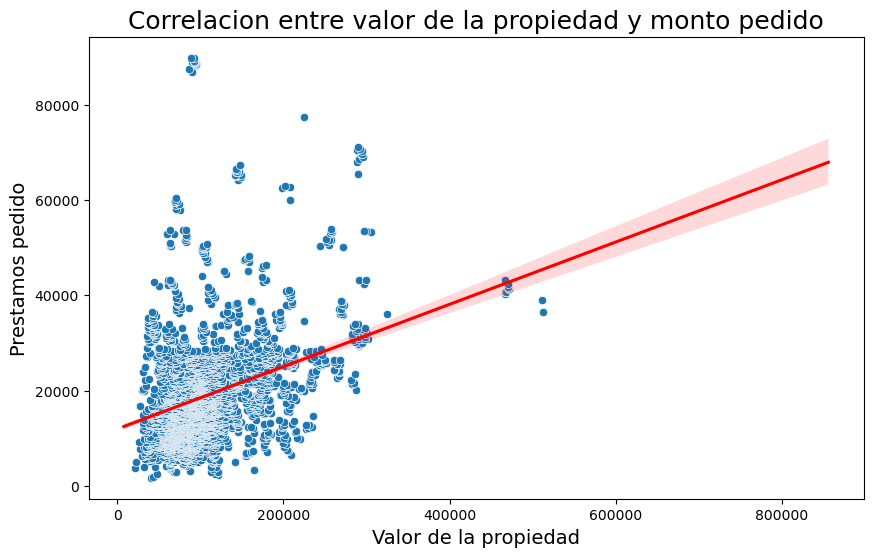

In [34]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='VALUE', y='LOAN', data=df_clean)
sns.regplot(x='VALUE', y='LOAN', data=df, scatter=False, color='red')

plt.title('Correlacion entre valor de la propiedad y monto pedido', fontsize=18)
plt.xlabel('Valor de la propiedad', fontsize=14)
plt.ylabel('Prestamos pedido', fontsize=14)

plt.show()

### Distribución del Monto adeudado en la hipoteca existente y Correlación con el monto pedido

In [35]:
from scipy.stats import pearsonr

# Suponiendo que tienes dos variables 'x' y 'y' en un DataFrame 'df'
corr, p_value = pearsonr(df_clean['MORTDUE'], df_clean['LOAN'])

print(f"Correlación de Pearson: {corr}")
print(f"Valor p: {p_value}")

Correlación de Pearson: 0.27292428022031506
Valor p: 1.5469496383610435e-58


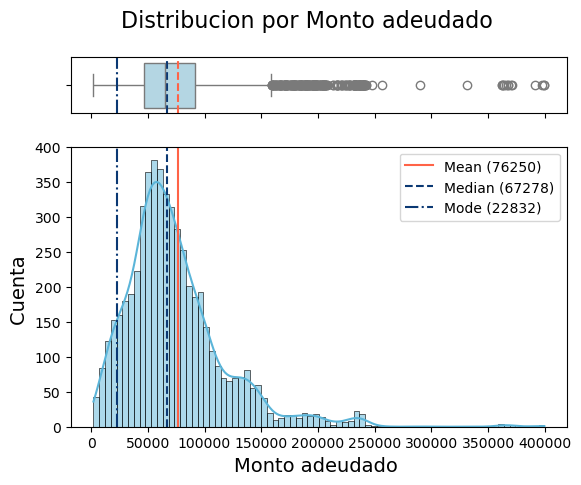

In [36]:
mean = df_clean['MORTDUE'].mean()
median = df_clean['MORTDUE'].median()
mode = df_clean['MORTDUE'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="MORTDUE", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="MORTDUE", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel('Monto adeudado ', fontsize=14)

f.suptitle('Distribucion por Monto adeudado ', fontsize=16)
plt.show()

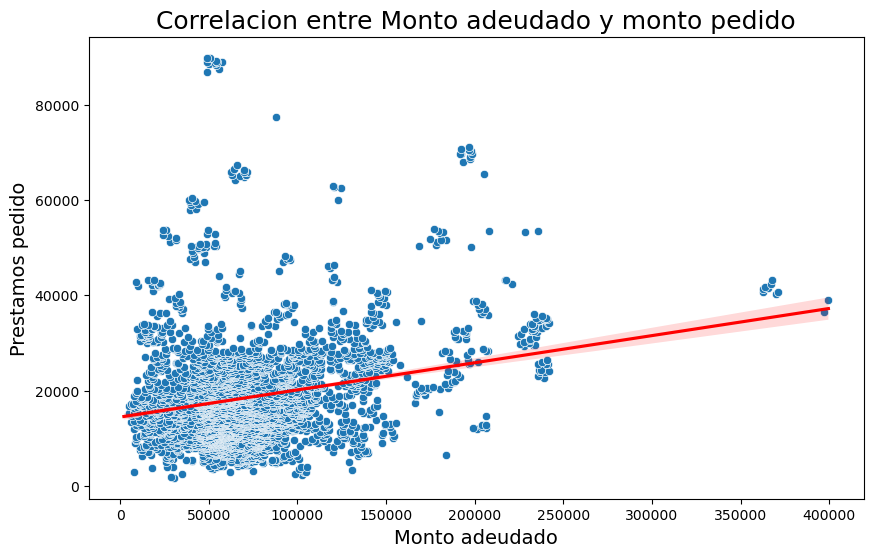

In [37]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='MORTDUE', y='LOAN', data=df_clean)
sns.regplot(x='MORTDUE', y='LOAN', data=df, scatter=False, color='red')

plt.title('Correlacion entre Monto adeudado y monto pedido', fontsize=18)
plt.xlabel('Monto adeudado', fontsize=14)
plt.ylabel('Prestamos pedido', fontsize=14)

plt.show()

### Distribución de informes de morosidad y Correlación con el monto pedido

In [38]:
from scipy.stats import pearsonr

# Suponiendo que tienes dos variables 'x' y 'y' en un DataFrame 'df'
corr, p_value = pearsonr(df_clean['DEROG'], df_clean['LOAN'])

print(f"Correlación de Pearson: {corr}")
print(f"Valor p: {p_value}")

Correlación de Pearson: -0.024263298927162634
Valor p: 0.15944060111036018


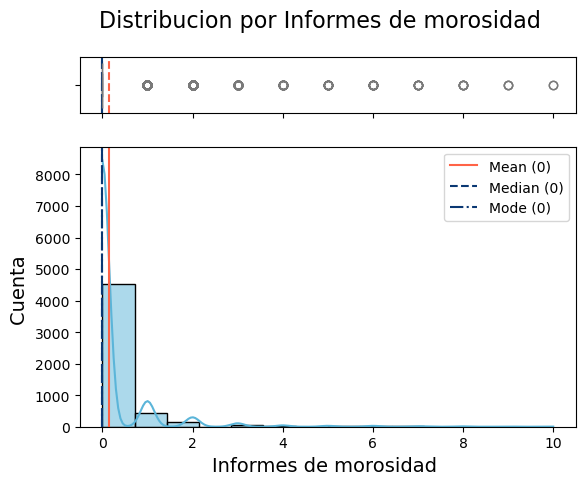

In [39]:
mean = df_clean['DEROG'].mean()
median = df_clean['DEROG'].median()
mode = df_clean['DEROG'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="DEROG", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="DEROG", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel('Informes de morosidad ', fontsize=14)

f.suptitle('Distribucion por Informes de morosidad', fontsize=16)
plt.show()

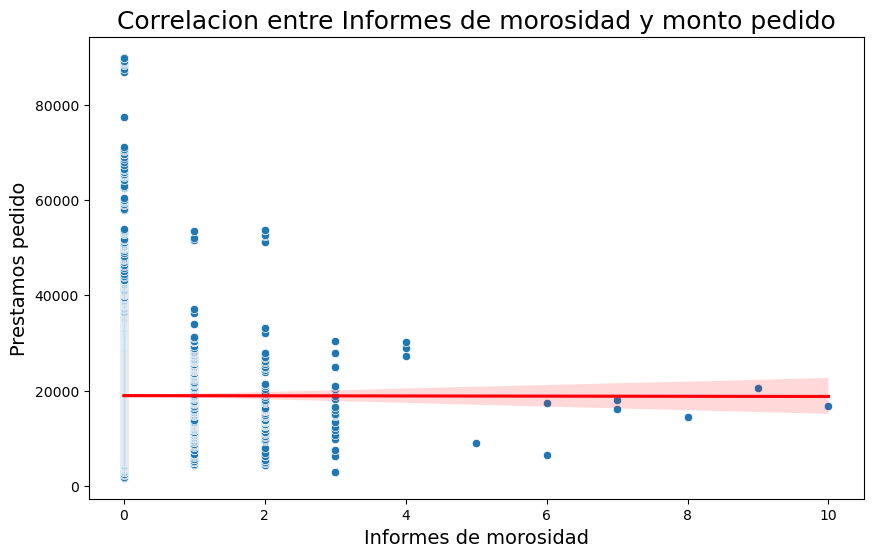

In [40]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='DEROG', y='LOAN', data=df_clean)
sns.regplot(x='DEROG', y='LOAN', data=df, scatter=False, color='red')

plt.title('Correlacion entre Informes de morosidad y monto pedido', fontsize=18)
plt.xlabel('Informes de morosidad', fontsize=14)
plt.ylabel('Prestamos pedido', fontsize=14)

plt.show()

### Distribución de Número de líneas de crédito morosas y Correlación con el monto pedido

In [41]:
from scipy.stats import pearsonr

# Suponiendo que tienes dos variables 'x' y 'y' en un DataFrame 'df'
corr, p_value = pearsonr(df_clean['DELINQ'], df_clean['LOAN'])

print(f"Correlación de Pearson: {corr}")
print(f"Valor p: {p_value}")

Correlación de Pearson: -0.06746802386333872
Valor p: 8.997292066250508e-05


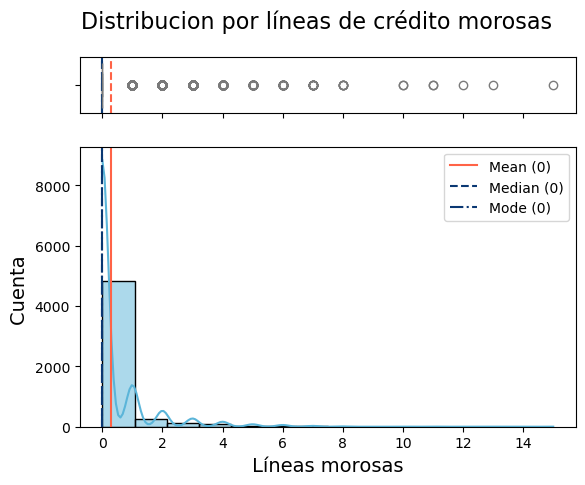

In [42]:
mean = df_clean['DELINQ'].mean()
median = df_clean['DELINQ'].median()
mode = df_clean['DELINQ'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="DELINQ", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="DELINQ", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel(' Líneas morosas ', fontsize=14)

f.suptitle('Distribucion por líneas de crédito morosas ', fontsize=16)
plt.show()

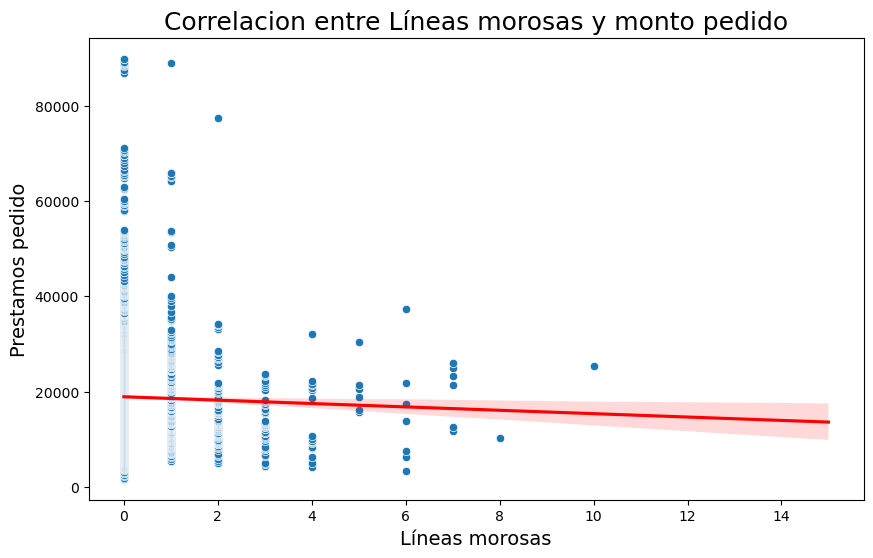

In [43]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='DELINQ', y='LOAN', data=df_clean)
sns.regplot(x='DELINQ', y='LOAN', data=df, scatter=False, color='red')

plt.title('Correlacion entre Líneas morosas y monto pedido', fontsize=18)

plt.xlabel('Líneas morosas', fontsize=14)
plt.ylabel('Prestamos pedido', fontsize=14)

plt.show()

# Correlación con incumplimiento de pago

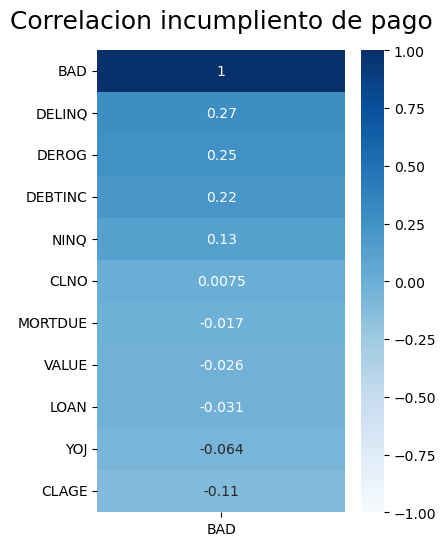

In [44]:
# Definir la variable de interés y las columnas numéricas
var_int = [
    'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ',
    'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'BAD'
]

# Crear el heatmap para la variable 'LOAN' con los datos limpios (df_clean)
plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(df_clean[var_int].corr()[['BAD']].sort_values(by='BAD', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlacion incumpliento de pago', fontdict={'fontsize': 18}, pad=16)
plt.show()

DELINQ, DEROG, y DEBTINC, ya que estas están moderadamente correlacionadas con la probabilidad de incumplimiento. Las personas con más líneas de crédito morosas, un historial de morosidad grave y una alta relación deuda-ingreso son más propensas a incumplir.

Por otro lado, variables como la antigüedad de la línea de crédito (CLAGE) y los años en el empleo actual (YOJ) parecen ser factores estabilizadores que reducen el riesgo de incumplimiento

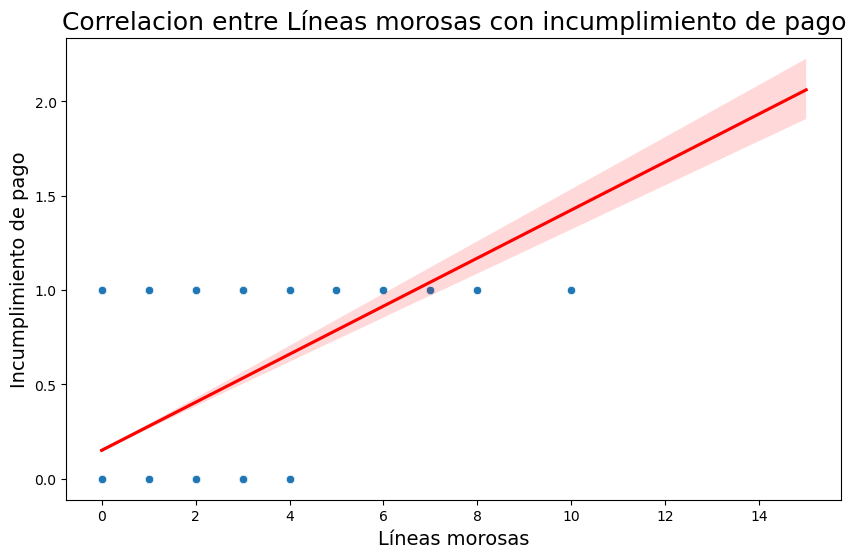

In [45]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='DELINQ', y='BAD', data=df_clean)
sns.regplot(x='DELINQ', y='BAD', data=df, scatter=False, color='red')

plt.title('Correlacion entre Líneas morosas con incumplimiento de pago', fontsize=18)

plt.xlabel('Líneas morosas', fontsize=14)
plt.ylabel('Incumplimiento de pago', fontsize=14)

plt.show()

In [46]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(df_clean['BAD'], df_clean['DELINQ'])

print(f"Correlación con Líneas morosas: {corr}")
print(f"Valor p: {p_value}")

Correlación con Líneas morosas: 0.2748934302509327
Valor p: 2.1625688061992152e-59


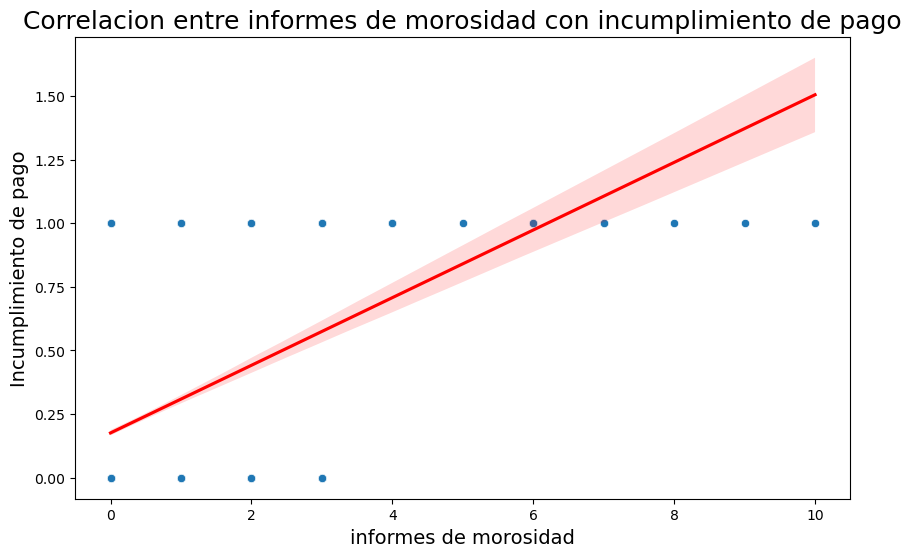

In [47]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='DEROG', y='BAD', data=df_clean)
sns.regplot(x='DEROG', y='BAD', data=df, scatter=False, color='red')

plt.title('Correlacion entre informes de morosidad con incumplimiento de pago', fontsize=18)

plt.xlabel('informes de morosidad', fontsize=14)
plt.ylabel('Incumplimiento de pago', fontsize=14)

plt.show()

In [48]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(df_clean['BAD'], df_clean['DEROG'])

print(f"Correlación con informes de morosidad: {corr}")
print(f"Valor p: {p_value}")

Correlación con informes de morosidad: 0.25371072147716767
Valor p: 1.4426102363516186e-50


### Distribución de Relación deuda-ingreso y Correlación con el incumplimiento de pago

In [49]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(df_clean['BAD'], df_clean['DEBTINC'])

print(f"Correlación con Relación deuda-ingreso: {corr}")
print(f"Valor p: {p_value}")

Correlación con Relación deuda-ingreso: 0.21695880014658853
Valor p: 3.984168731056291e-37


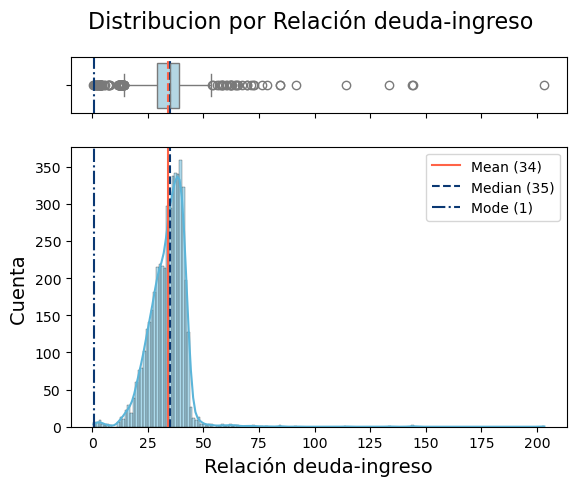

In [50]:
mean = df_clean['DEBTINC'].mean()
median = df_clean['DEBTINC'].median()
mode = df_clean['DEBTINC'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="DEBTINC", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="DEBTINC", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel(' Relación deuda-ingreso ', fontsize=14)

f.suptitle('Distribucion por Relación deuda-ingreso', fontsize=16)
plt.show()

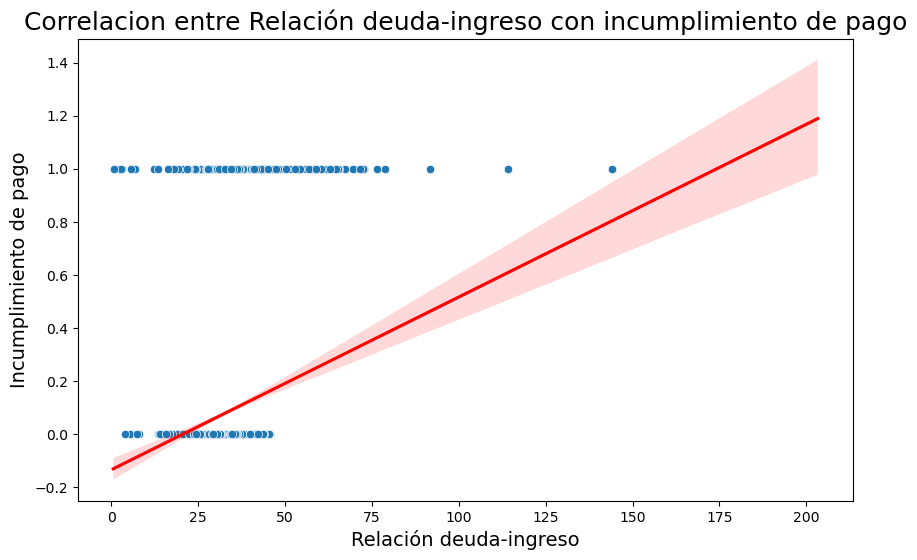

In [51]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='DEBTINC', y='BAD', data=df_clean)
sns.regplot(x='DEBTINC', y='BAD', data=df, scatter=False, color='red')

plt.title('Correlacion entre Relación deuda-ingreso con incumplimiento de pago', fontsize=18)

plt.xlabel('Relación deuda-ingreso', fontsize=14)
plt.ylabel('Incumplimiento de pago', fontsize=14)

plt.show()

### Distribución de la linea mas antigua y Correlación con el incumplimiento de pago

In [52]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(df_clean['BAD'], df_clean['CLAGE'])

print(f"Correlación con  linea mas antigua: {corr}")
print(f"Valor p: {p_value}")

Correlación con  linea mas antigua: -0.11390574371847098
Valor p: 3.457200818306653e-11


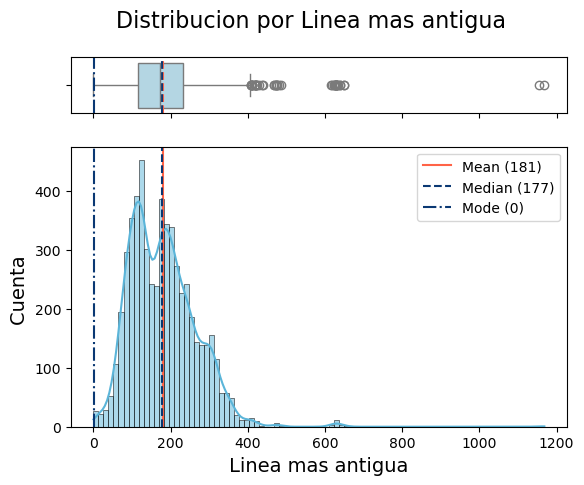

In [53]:
mean = df_clean['CLAGE'].mean()
median = df_clean['CLAGE'].median()
mode = df_clean['CLAGE'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="CLAGE", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="CLAGE", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel(' Linea mas antigua ', fontsize=14)

f.suptitle('Distribucion por Linea mas antigua', fontsize=16)
plt.show()

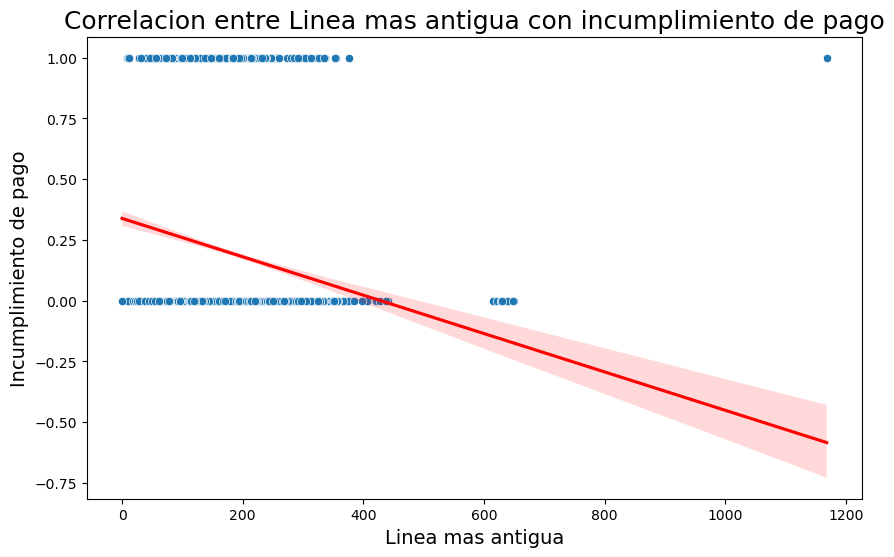

In [54]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='CLAGE', y='BAD', data=df_clean)
sns.regplot(x='CLAGE', y='BAD', data=df, scatter=False, color='red')

plt.title('Correlacion entre Linea mas antigua con incumplimiento de pago', fontsize=18)

plt.xlabel('Linea mas antigua', fontsize=14)
plt.ylabel('Incumplimiento de pago', fontsize=14)

plt.show()

### Distribución de años en el empleo actual y Correlación con el incumplimiento de pago

In [55]:
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(df_clean['BAD'], df_clean['YOJ'])

print(f"Correlación con años en el empleo actual: {corr}")
print(f"Valor p: {p_value}")

Correlación con años en el empleo actual: -0.06427898064944174
Valor p: 0.00019098363769161833


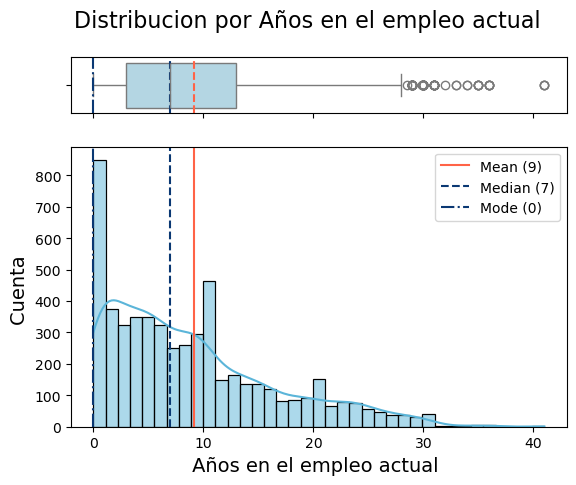

In [56]:
mean = df_clean['YOJ'].mean()
median = df_clean['YOJ'].median()
mode = df_clean['YOJ'].mode().values[0]

palette = sns.color_palette(["#0A3873", "#1261A6", "#4590BF", "#4590BF", "#5BB5D9"])

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)})

sns.boxplot(data=df, x="YOJ", ax=ax_box, color="#ACD9EB")
ax_box.axvline(mean, color='tomato', linestyle='--')
ax_box.axvline(median, color=palette[0], linestyle='dashed')
ax_box.axvline(mode, color=palette[0], linestyle='dashdot')

sns.histplot(data=df, x="YOJ", ax=ax_hist, kde=True, color=palette[4])
ax_hist.axvline(mean, color='tomato', linestyle='solid', label=f"Mean ({mean:.0f})")
ax_hist.axvline(median, color=palette[0], linestyle='dashed', label=f"Median ({median:.0f})")
ax_hist.axvline(mode, color=palette[0], linestyle='dashdot', label=f"Mode ({mode:.0f})")
ax_hist.legend()

plt.ylabel('Cuenta ', fontsize=14)
plt.xlabel(' Años en el empleo actual  ', fontsize=14)

f.suptitle('Distribucion por Años en el empleo actual ', fontsize=16)
plt.show()

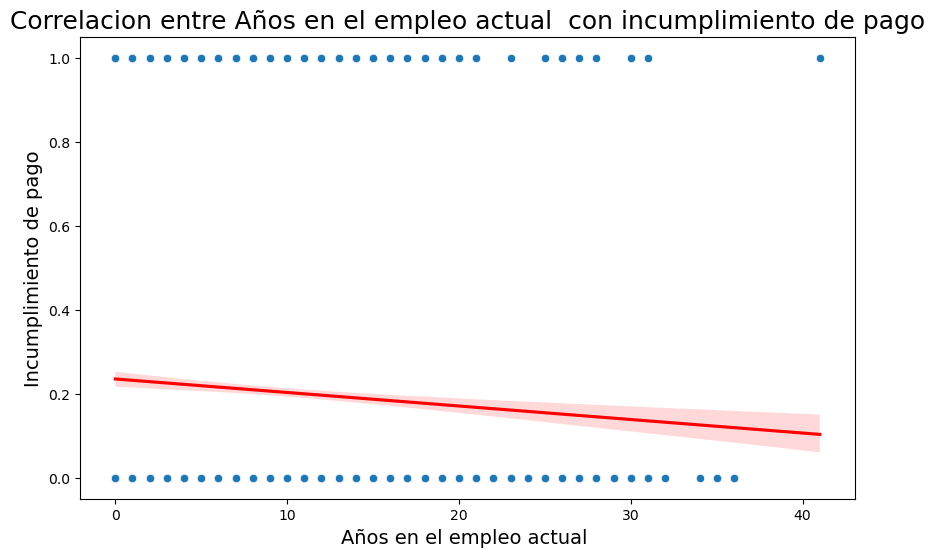

In [57]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='YOJ', y='BAD', data=df_clean)
sns.regplot(x='YOJ', y='BAD', data=df, scatter=False, color='red')

plt.title('Correlacion entre Años en el empleo actual  con incumplimiento de pago', fontsize=18)

plt.xlabel('Años en el empleo actual ', fontsize=14)
plt.ylabel('Incumplimiento de pago', fontsize=14)

plt.show()

# Correlación con Tipo de trabajo y Razón

In [58]:
# Convertir la columna JOB a variables numéricas usando One-Hot Encoding
df_clean_encoded = pd.get_dummies(df_clean, columns=['JOB'])

# Seleccionar solo las columnas numéricas
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

# Crear una matriz de correlación entre las columnas numéricas y las variables de trabajo
job_correlation_matrix = df_clean_encoded[numeric_columns + list(df_clean_encoded.columns[df_clean_encoded.columns.str.contains('JOB')])].corr()

# Mostrar la matriz de correlación
job_correlation_matrix


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
LOAN,1.000000,0.272924,0.378724,0.076359,-0.024263,-0.067468,0.066484,0.051264,0.075893,0.157379,0.044196,-0.065616,-0.070544,0.030326,-0.051740,0.218890
MORTDUE,0.272924,1.000000,0.865265,-0.103307,-0.042590,-0.035903,0.137741,0.036424,0.320759,0.185446,0.061584,-0.070627,-0.253691,0.237213,-0.025134,0.160341
VALUE,0.378724,0.865265,1.000000,-0.021113,-0.045910,-0.068415,0.197697,-0.006878,0.215466,0.130928,0.009735,-0.081197,-0.257361,0.274645,-0.033377,0.206963
YOJ,0.076359,-0.103307,-0.021113,1.000000,-0.055824,0.021976,0.230511,-0.045865,-0.001290,-0.051864,0.031660,-0.033601,0.062190,-0.025484,-0.045838,-0.067137
DEROG,-0.024263,-0.042590,-0.045910,-0.055824,1.000000,0.147825,-0.053741,0.181596,0.065897,0.035200,0.025497,-0.032297,0.036055,-0.052190,0.079170,-0.004669
DELINQ,-0.067468,-0.035903,-0.068415,0.021976,0.147825,1.000000,0.011583,0.003523,0.122612,0.038251,0.001644,0.030308,0.002583,-0.013005,-0.031784,-0.020869
CLAGE,0.066484,0.137741,0.197697,0.230511,-0.053741,0.011583,1.000000,-0.089076,0.201759,-0.050553,-0.017350,-0.023809,-0.127055,0.143905,0.019692,0.062072
NINQ,0.051264,0.036424,-0.006878,-0.045865,0.181596,0.003523,-0.089076,1.000000,0.077538,0.157328,0.115613,-0.046113,0.042175,-0.098267,-0.027707,0.026439
CLNO,0.075893,0.320759,0.215466,-0.001290,0.065897,0.122612,0.201759,0.077538,1.000000,0.143613,0.006944,0.008833,-0.164814,0.120337,0.042970,0.093455
DEBTINC,0.157379,0.185446,0.130928,-0.051864,0.035200,0.038251,-0.050553,0.157328,0.143613,1.000000,0.045540,0.020569,0.016126,-0.111437,0.034887,0.082108


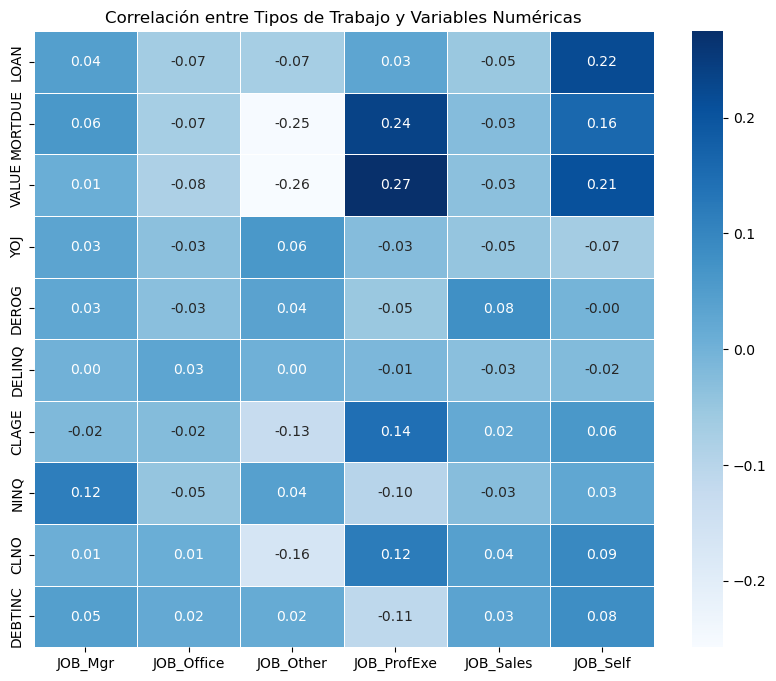

In [59]:
# Crear un heatmap donde en X solo estén los trabajos y en Y las otras variables numéricas
job_columns = [col for col in job_correlation_matrix.columns if 'JOB_' in col]
numeric_columns_only = [col for col in numeric_columns if col in job_correlation_matrix.columns]

# Crear una nueva matriz de correlación solo con trabajos en X y variables numéricas en Y
correlation_subset = job_correlation_matrix.loc[numeric_columns_only, job_columns]

# Crear el heatmap con una máscara para la nueva matriz
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Título del heatmap
plt.title('Correlación entre Tipos de Trabajo y Variables Numéricas')

# Mostrar el gráfico
plt.show()

> Trabajadores por cuenta propia y profesionales/ejecutivos tienden a tener mayores préstamos, deudas hipotecarias y propiedades de mayor valor.
Trabajadores en categorías genéricas tienden a tener préstamos y deudas hipotecarias más bajas.
Otros tipos de trabajo como ventas o administrativos no parecen tener correlaciones fuertes con las variables numéricas.

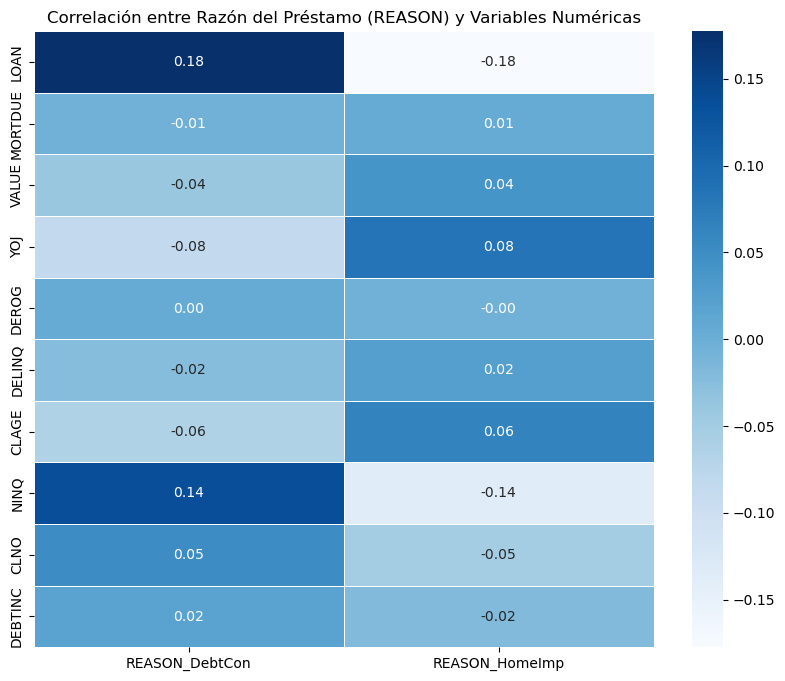

In [60]:

# Crear la matriz de correlación para 'REASON' contra las otras categorías (menos JOB)
df_clean_encoded_reason = pd.get_dummies(df_clean, columns=['REASON'])

# Crear una nueva matriz de correlación que incluya solo las columnas numéricas y las variables de REASON
correlation_matrix_reason = df_clean_encoded_reason[numeric_columns + list(df_clean_encoded_reason.columns[df_clean_encoded_reason.columns.str.contains('REASON')])].corr()

# Filtrar la matriz de correlación para mostrar solo REASON en X y las otras variables numéricas en Y
reason_columns = [col for col in correlation_matrix_reason.columns if 'REASON_' in col]
correlation_subset_reason = correlation_matrix_reason.loc[numeric_columns, reason_columns]

# Crear el heatmap para REASON vs las otras categorías numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset_reason, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Título del heatmap
plt.title('Correlación entre Razón del Préstamo (REASON) y Variables Numéricas')

# Mostrar el gráfico
plt.show()



> Las personas que solicitan préstamos para consolidación de deudas tienden a pedir montos más altos y tienen más consultas de crédito recientes.
Las personas que solicitan préstamos para mejoras en la vivienda tienden a pedir montos más bajos y, en general, tienen más estabilidad laboral (más años en el empleo actual).

# Preprocessing (Mike)

## Dataset Description


In [ ]:
data = pd.read_csv("hmeq.csv")

data.shape

(5960, 13)

In [ ]:
data['BAD'].value_counts()

BAD
0    4771
1    1189
Name: count, dtype: int64

In [ ]:
X = data.drop(columns=['BAD'])
y = data['BAD']

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categoric_features = X.select_dtypes(include=['object']).columns

In [ ]:
data[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000
DEBTINC,4693.0,33.779915,8.601746,0.524499,29.140031,34.818262,39.003141,203.312149


In [ ]:
X[categoric_features].describe().T

,count,unique,top,freq
REASON,5708,2,DebtCon,3928
JOB,5681,6,Other,2388


### Nulls

In [ ]:
null_percentage = np.round(data.isnull().sum() * 100 / len(data), 2)

missing_values_df = pd.DataFrame({'missing_values_%': null_percentage})
missing_values_df

,missing_values_%
BAD,0.00
LOAN,0.00
MORTDUE,8.69
VALUE,1.88
REASON,4.23
JOB,4.68
YOJ,8.64
DEROG,11.88
DELINQ,9.73
CLAGE,5.17


### Duplicate data

In [ ]:
data.duplicated().sum()

0

### Imputing nulls

In [ ]:
data['JOB'] = data['JOB'].fillna('Other')

In [ ]:
medians_job = data.groupby('JOB')[['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']].median()
medians_job = medians_job.reset_index()
medians_job = medians_job.rename(columns={'MORTDUE': 'MED_MORTDUE', 'VALUE': 'MED_VALUE', 
'YOJ': 'MED_YOJ', 'DEROG': 'MED_DEROG', 'DELINQ': 'MED_DELINQ', 'CLAGE': 'MED_CLAGE', 
'NINQ': 'MED_NINQ', 'CLNO': 'MED_CLNO', 'DEBTINC': 'MED_DEBTINC'})
mode_reason = data.groupby('JOB')[['REASON']].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_reason = mode_reason.rename(columns={'REASON': 'MED_MODREASON'})

In [ ]:
mode_reason

,JOB,MED_MODREASON
0,Mgr,DebtCon
1,Office,DebtCon
2,Other,DebtCon
3,ProfExe,DebtCon
4,Sales,DebtCon
5,Self,HomeImp


In [ ]:
medians_job.head()

,JOB,MED_MORTDUE,MED_VALUE,MED_YOJ,MED_DEROG,MED_DELINQ,MED_CLAGE,MED_NINQ,MED_CLNO,MED_DEBTINC
0,Mgr,76600.0,101258.0,8.0,0.0,0.0,171.214416,1.0,23.0,35.661118
1,Office,62970.5,89094.5,6.0,0.0,0.0,171.135632,1.0,20.0,36.158718
2,Other,55000.0,76864.5,7.0,0.0,0.0,156.204497,1.0,17.5,34.571519
3,ProfExe,82802.5,110007.0,8.0,0.0,0.0,185.170637,1.0,24.0,33.378041
4,Sales,71800.0,84473.5,4.0,0.0,0.0,147.355313,0.0,23.0,35.764058


In [ ]:
data_to_get_okey = pd.merge(data, medians_job, on='JOB', how='left')
data_to_get_okey = data_to_get_okey.fillna({'MORTDUE': data_to_get_okey['MED_MORTDUE'], 
'VALUE': data_to_get_okey['MED_VALUE'], 
'YOJ': data_to_get_okey['MED_YOJ'], 
'DEROG': data_to_get_okey['MED_DEROG'], 
'DELINQ': data_to_get_okey['MED_DELINQ'], 
'CLAGE': data_to_get_okey['MED_CLAGE'],
'NINQ': data_to_get_okey['MED_NINQ'], 
'CLNO': data_to_get_okey['MED_CLNO'],
'DEBTINC': data_to_get_okey['MED_DEBTINC']}).drop(data_to_get_okey.filter(regex='^MED_').columns, axis=1)
data_okey =  pd.merge(data_to_get_okey, mode_reason, on='JOB', how='left')
data_okey = data_okey.fillna({'REASON': data_okey['MED_MODREASON']}).drop(['MED_MODREASON'], axis=1)

In [ ]:
null_percentage = np.round(data_okey.isnull().sum() * 100 / len(data_okey), 2)

missing_values_df = pd.DataFrame({'missing_values_%': null_percentage})
missing_values_df

,missing_values_%
BAD,0.0
LOAN,0.0
MORTDUE,0.0
VALUE,0.0
REASON,0.0
JOB,0.0
YOJ,0.0
DEROG,0.0
DELINQ,0.0
CLAGE,0.0


In [ ]:
data_okey

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.571519
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.571519
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.571519
3,1,1500,55000.0,76864.5,DebtCon,Other,7.0,0.0,0.0,156.204497,1.0,17.5,34.571519
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,36.158718
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


### Cast columns

In [ ]:
data_okey.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [ ]:
categoric_features = ['BAD', 'REASON', 'JOB']
data_okey[categoric_features] = data_okey[categoric_features].apply(lambda col: col.astype('category'))

In [ ]:
data_okey.dtypes

BAD        category
LOAN          int64
MORTDUE     float64
VALUE       float64
REASON     category
JOB        category
YOJ         float64
DEROG       float64
DELINQ      float64
CLAGE       float64
NINQ        float64
CLNO        float64
DEBTINC     float64
dtype: object

### Detecting outliers

In [ ]:
def find_outliers_iqr(df, columns=None):
    # If no specific columns are provided, use only numeric columns
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    # Create an empty list to store whether a row contains any outlier
    outlier_flags = []
    
    # Precompute IQR bounds for each numeric column
    iqr_bounds = {}
    for col in columns:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_bounds[col] = (lower_bound, upper_bound)
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        row_outlier = False  # Initialize flag for each row
        
        # Check each numeric column for an outlier using the precomputed bounds
        for col in columns:
            lower_bound, upper_bound = iqr_bounds[col]
            
            # Check if the current value in this row and column is an outlier
            if row[col] < lower_bound or row[col] > upper_bound:
                row_outlier = True
                break  # Stop checking other columns for this row once an outlier is found
        
        # Append 'Outlier' or 'Not Outlier' based on the row_outlier flag
        outlier_flags.append('Outlier' if row_outlier else 'Not Outlier')
    
    # Add a new column to the DataFrame
    df['outlier_flag'] = outlier_flags
    
    return df

In [ ]:
outliers = find_outliers_iqr(data_okey)

In [ ]:
outliers.groupby('outlier_flag').size()

outlier_flag
Not Outlier    5947
Outlier          13
dtype: int64

### Save clean data

In [ ]:
outliers.to_csv("use_to_divide.csv", index=False, encoding="utf-8")

# Create train, test & validation set

In [ ]:
df_to_divide = pd.read_csv("use_to_divide.csv")

df_to_divide.shape

(5960, 14)

Filtramos para quedarnos sin outliers

In [ ]:
data_without_outliers = df_to_divide[df_to_divide['outlier_flag']=='Not Outlier'].drop(['outlier_flag'], axis=1)

In [ ]:
data_without_outliers.shape

(5947, 13)

Dividimos en train, test y validación

In [ ]:
categoric_features = ['BAD', 'REASON', 'JOB']
data_without_outliers[categoric_features] = data_without_outliers[categoric_features].apply(lambda col: col.astype('category'))

In [ ]:
train_df, test_df = train_test_split(data_without_outliers, test_size=0.5,random_state=1)
test_df, val_df = train_test_split(test_df, test_size=0.3, random_state=1)

In [ ]:
display(len(train_df), len(test_df), len(val_df)) 

2973

2081

893

In [ ]:
per_data = []

# Iterate over columns of object dtype
for col in val_df.select_dtypes(include=['object', 'category']):
    # Calculate value counts as percentages
    percentages = val_df[col].value_counts(normalize=True) * 100
    # Iterate over each value and its percentage
    for category, percentage in percentages.items():
        # Append data as a dictionary
        per_data.append({'Column': col, 'Category': category, 'Percentage': percentage})

# Create a new DataFrame from the list of dictionaries
#train_df_per = pd.DataFrame(per_data)
#test_df_per = pd.DataFrame(per_data)
val_df_per = pd.DataFrame(per_data)

In [ ]:
train_df.to_csv("train_df.csv", index=False, encoding="utf-8")
test_df.to_csv("test_df.csv", index=False, encoding="utf-8")
val_df.to_csv("val_df.csv", index=False, encoding="utf-8")

# Feature selection

### Checking variance (only numerical variable)

We seek to keep those variables that contribute significant variance to the model and eliminate those that do not.

In [ ]:
train_df = pd.read_csv("train_df.csv")

In [ ]:
categoric_features = ['BAD', 'REASON', 'JOB']
train_df[categoric_features] = train_df[categoric_features].apply(lambda col: col.astype('category'))

In [ ]:
numeric_features = train_df.select_dtypes(include=['int', 'float']).columns.tolist()


In [ ]:
scaler = MinMaxScaler(feature_range=(10, 100))
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

In [ ]:
vt = VarianceThreshold(threshold=0.15)

In [ ]:
vt.fit(train_df[numeric_features])

VarianceThreshold(threshold=0.15)

In [ ]:
varianza_peq = [v for v,nu in zip(train_df[numeric_features].columns,vt.get_support()) if not nu]
len(varianza_peq)

0

### Applying BinningProcess (Numeric & Categorical Columns)

In [ ]:
X = train_df.drop(columns=['BAD'])
y = train_df['BAD']

In [ ]:
categoric_features = ['REASON', 'JOB']

In [ ]:
label_encoders = {}

for column in categoric_features:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

In [ ]:
vc = VarClusHi(df = X)
vc.varclus()

In [ ]:
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster', 'RS_Ratio']).reset_index(drop = True)
rs['id'] = rs.groupby('Cluster').cumcount()+1

In [ ]:
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,VALUE,0.884121,0.106870,0.129745,1
1,0,MORTDUE,0.804553,0.096080,0.216221,2
2,0,LOAN,0.290790,0.015217,0.720169,3
3,0,JOB,0.086597,0.007061,0.919898,4
4,1,NINQ,0.499697,0.015778,0.508323,1
5,1,DEBTINC,0.284991,0.016091,0.726703,2
6,1,REASON,0.226929,0.004625,0.776663,3
7,1,YOJ,0.231415,0.017636,0.782384,4
8,2,DELINQ,0.599143,0.016819,0.407715,1
9,2,DEROG,0.599143,0.020065,0.409065,2


In [ ]:
variable_names = list(X.columns)

binning_process = BinningProcess(variable_names)
binning_process.fit(X, y)
binning_process.information(print_level=1)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                   2973
    Number of variables                   12
    Target type                       binary

    Number of numerical                   12
    Number of categorical                  0
    Number of selected                    12

  Time                                0.9875 sec



In [ ]:
df_bins_num  = binning_process.summary().sort_values(by = 'iv', ascending = False)
df_bins_num  = df_bins_num[df_bins_num['dtype'] == 'numerical']
df_bins_num.rename(columns = {'name': 'Variable'}, inplace = True)
df_bins_num = df_bins_num.merge(rs, how = 'left', on = 'Variable')
df_bins_num = df_bins_num.sort_values(by=['Cluster', 'iv'], ascending = [True, False]).reset_index(drop = True)
df_bins_num['id'] = rs.groupby('Cluster').cumcount()+1

In [ ]:
df_bins_num

,Variable,dtype,status,selected,n_bins,iv,js,gini,quality_score,Cluster,RS_Own,RS_NC,RS_Ratio,id
0,LOAN,numerical,OPTIMAL,True,7,0.219406,0.025989,0.217537,0.331389,0,0.290790,0.015217,0.720169,1
1,VALUE,numerical,OPTIMAL,True,7,0.16649,0.019847,0.182063,0.05667,0,0.884121,0.106870,0.129745,2
2,JOB,numerical,OPTIMAL,True,4,0.086211,0.010606,0.13631,0.218258,0,0.086597,0.007061,0.919898,3
3,MORTDUE,numerical,OPTIMAL,True,6,0.07867,0.009762,0.153565,0.0296,0,0.804553,0.096080,0.216221,4
4,DEBTINC,numerical,OPTIMAL,True,6,0.578483,0.066971,0.327112,0.073815,1,0.284991,0.016091,0.726703,1
5,NINQ,numerical,OPTIMAL,True,5,0.157684,0.019246,0.199603,0.143144,1,0.499697,0.015778,0.508323,2
6,YOJ,numerical,OPTIMAL,True,5,0.058729,0.007286,0.127383,0.026038,1,0.231415,0.017636,0.782384,3
7,REASON,numerical,OPTIMAL,True,2,0.008347,0.001043,0.042372,0.018633,1,0.226929,0.004625,0.776663,4
8,DELINQ,numerical,OPTIMAL,True,3,0.558981,0.064127,0.319013,0.368205,2,0.599143,0.016819,0.407715,1
9,DEROG,numerical,OPTIMAL,True,2,0.374568,0.043935,0.224687,0.278902,2,0.599143,0.020065,0.409065,2


IV > 0.15
- 0: LOAN, VALUE
- 1: DEBTINC, NINQ
- 2: DELINQ, DEROG
- 3: CLAGE


# Train

## Balanced with all variables

### Training

In [ ]:
train_df = pd.read_csv("train_df.csv")
#train_df = train_df[['BAD', 'LOAN', 'VALUE', 'DEBTINC', 'NINQ', 'DELINQ', 'DEROG', 'CLAGE']]

In [ ]:
categoric_features = ['BAD', 'REASON', 'JOB']
#categoric_features = ['BAD']
train_df[categoric_features] = train_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

In [ ]:
# Submuestrear la clase mayoritaria (0)
df_majority = train_df[train_df['BAD'] == 0].sample(n=588, random_state=11)
df_minority = train_df[train_df['BAD'] == 1]

# Concatenar ambas muestras
train_df = pd.concat([df_majority, df_minority])


In [ ]:
train_df['BAD'].value_counts()

BAD
0    588
1    588
Name: count, dtype: int64

In [ ]:
X_train = train_df.drop(columns=['BAD'])
y_train = train_df['BAD']

In [ ]:
model = XGBClassifier()

In [ ]:
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', RobustScaler(), numeric_features)
#    ])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categoric_features)
    ])

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

In [ ]:
model_to_val = pipeline.fit(X_train, y_train)
#dump(pipeline, 'pipeline_model.joblib')

In [ ]:
model_to_val = load('pipeline_model.joblib')
preds_train = model_to_val.predict(X_train)

In [ ]:
acc_train = metrics.accuracy_score(y_train, preds_train)
pred_p = model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_p[:, 1])
auc_train = metrics.auc(fpr, tpr)
f1_train = metrics.f1_score(y_train, preds_train)
recall_train = metrics.recall_score(y_train, preds_train)
prcson_train = metrics.precision_score(y_train, preds_train)

In [ ]:
#ALL
print(f"accuracy_train:{acc_train}")
print(f"auc_train:{auc_train}")
print(f"f1_score_train:{f1_train}")
print(f"recall_train:{recall_train}")
print(f"precision_train:{prcson_train}")
print(classification_report(y_train, preds_train))

accuracy_train:1.0
auc_train:0.3653570271646074
f1_score_train:1.0
recall_train:1.0
precision_train:1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       588
           1       1.00      1.00      1.00       588

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



In [ ]:
#FEW
print(f"accuracy_train:{acc_train}")
print(f"auc_train:{auc_train}")
print(f"f1_score_train:{f1_train}")
print(f"recall_train:{recall_train}")
print(f"precision_train:{prcson_train}")
print(classification_report(y_train, preds_train))

accuracy_train:1.0
auc_train:0.6799698620944977
f1_score_train:1.0
recall_train:1.0
precision_train:1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       588
           1       1.00      1.00      1.00       588

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



In [ ]:
conf_matrix_train = metrics.confusion_matrix(y_train, preds_train)

In [ ]:
conf_matrix_train

array([[588,   0],
       [  0, 588]])

### Testing

In [ ]:
test_df = pd.read_csv("test_df.csv")
#test_df = test_df[['BAD', 'LOAN', 'VALUE', 'DEBTINC', 'NINQ', 'DELINQ', 'DEROG', 'CLAGE']]

In [ ]:
categoric_features = ['BAD', 'REASON', 'JOB']
#categoric_features = ['BAD']
test_df[categoric_features] = test_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = test_df.select_dtypes(include=['int', 'float']).columns.tolist()
#categoric_features = ['REASON', 'JOB']
X_test = test_df.drop(columns=['BAD'])
y_test = test_df['BAD']

In [ ]:
# Cargar el pipeline guardado
loaded_pipeline = load('pipeline_model.joblib')

# Usar el pipeline cargado para predecir
predictions = loaded_pipeline.predict(X_test)

In [ ]:
acc_test = metrics.accuracy_score(y_test, predictions)
pred_ptest = loaded_pipeline.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_ptest[:, 1])
auc_test = metrics.auc(fpr, tpr)
f1_test = metrics.f1_score(y_test, predictions)
recall_test = metrics.recall_score(y_test, predictions)
prcson_test = metrics.precision_score(y_test, predictions)

In [ ]:
#ALL
print(f"accuracy_train:{acc_test}")
print(f"auc_train:{auc_test}")
print(f"f1_score_train:{f1_test}")
print(f"recall_train:{recall_test}")
print(f"precision_train:{prcson_test}")
print(classification_report(y_test, predictions))

accuracy_train:0.8505526189332052
auc_train:0.9171977973404969
f1_score_train:0.6959921798631477
recall_train:0.8416075650118203
precision_train:0.5933333333333334
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1658
           1       0.59      0.84      0.70       423

    accuracy                           0.85      2081
   macro avg       0.77      0.85      0.80      2081
weighted avg       0.88      0.85      0.86      2081



In [ ]:
conf_matrix_test = metrics.confusion_matrix(y_test, predictions)
conf_matrix_test

array([[1414,  244],
       [  67,  356]])

In [ ]:
#FEW
print(f"accuracy_train:{acc_test}")
print(f"auc_train:{auc_test}")
print(f"f1_score_train:{f1_test}")
print(f"recall_train:{recall_test}")
print(f"precision_train:{prcson_test}")
print(classification_report(y_test, predictions))

accuracy_train:0.829889476213359
auc_train:0.8899026711951794
f1_score_train:0.6647727272727273
recall_train:0.8297872340425532
precision_train:0.5545023696682464
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1658
           1       0.55      0.83      0.66       423

    accuracy                           0.83      2081
   macro avg       0.75      0.83      0.78      2081
weighted avg       0.87      0.83      0.84      2081



In [ ]:
conf_matrix_test = metrics.confusion_matrix(y_test, predictions)
conf_matrix_test

array([[1376,  282],
       [  72,  351]])

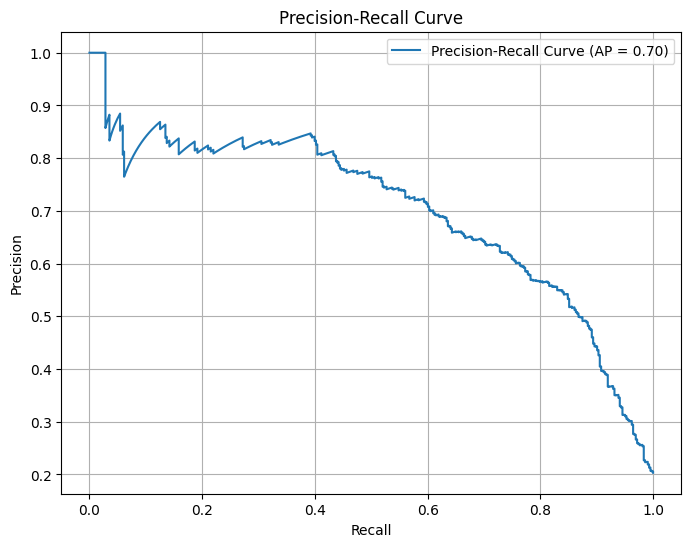

In [ ]:
# FEW
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Suponiendo que tienes X_test y y_test
# Obtener las probabilidades de la clase positiva
y_scores = loaded_pipeline.predict_proba(X_test)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_test, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


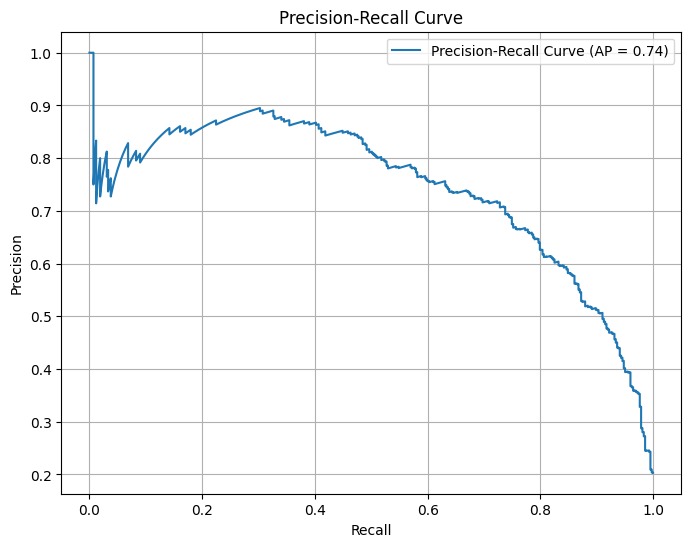

In [ ]:
# ALL
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Suponiendo que tienes X_test y y_test
# Obtener las probabilidades de la clase positiva
y_scores = pipeline.predict_proba(X_test)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_test, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

## 

# Tuneo

In [ ]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")


categoric_features = ['BAD', 'REASON', 'JOB']
train_df[categoric_features] = train_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

categoric_features = ['BAD', 'REASON', 'JOB']
val_df[categoric_features] = val_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = val_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

categoric_features = ['BAD', 'REASON', 'JOB']
test_df[categoric_features] = test_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = test_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

X_val = val_df.drop(columns=['BAD'])
y_val = val_df['BAD']

X_train = train_df.drop(columns=['BAD'])
y_train = train_df['BAD']

X_test = test_df.drop(columns=['BAD'])
y_test = test_df['BAD']

In [ ]:
def objective(trial):
    # Hiperparámetros que Optuna va a ajustar
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',  # Métrica de evaluación
        'n_estimators': trial.suggest_int('n_estimators', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categoric_features)
    ])

    # Crear el modelo XGBoost
    model = XGBClassifier(**param)

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

    # Usamos validación cruzada con StratifiedKFold
    skf = StratifiedKFold(n_splits=3)
    
    # Evaluamos el modelo con validación cruzada
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

    # Devolver la precisión promedio de la validación cruzada
    return scores.mean()

In [ ]:
# Crear el estudio Optuna y optimizar
study = optuna.create_study(direction='maximize')  # Queremos maximizar la recall
study.optimize(objective, n_trials=50)  # Probará 50 combinaciones de hiperparámetros

[I 2024-09-23 02:19:57,458] A new study created in memory with name: no-name-76ce6b38-2943-44f8-900a-e93b58347c35
[I 2024-09-23 02:19:57,578] Trial 0 finished with value: 0.4557823129251701 and parameters: {'n_estimators': 7, 'learning_rate': 0.16605442089091418, 'max_depth': 12}. Best is trial 0 with value: 0.4557823129251701.
[I 2024-09-23 02:19:57,652] Trial 1 finished with value: 0.48639455782312924 and parameters: {'n_estimators': 6, 'learning_rate': 0.2546700674611193, 'max_depth': 6}. Best is trial 1 with value: 0.48639455782312924.
[I 2024-09-23 02:19:57,757] Trial 2 finished with value: 0.41496598639455784 and parameters: {'n_estimators': 6, 'learning_rate': 0.16550449261500041, 'max_depth': 10}. Best is trial 1 with value: 0.48639455782312924.
[I 2024-09-23 02:19:57,891] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 9, 'learning_rate': 0.16794253361645126, 'max_depth': 7}. Best is trial 3 with value: 0.5.
[I 2024-09-23 02:19:57,974] Trial 4 finished with v

In [ ]:
# Mostrar los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", study.best_params)

Mejores Hiperparámetros: {'n_estimators': 9, 'learning_rate': 0.2792389076649859, 'max_depth': 11}


In [ ]:
# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
model = XGBClassifier(**best_params)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categoric_features)
    ])

pipeline_tuning = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

In [ ]:
model_tuning = pipeline_tuning.fit(X_train, y_train)

In [ ]:
dump(pipeline_tuning, 'pipeline_model_tuning.joblib')

['pipeline_model_tuning.joblib']

In [ ]:
model_tuning = load('pipeline_model_tuning.joblib')

In [ ]:
# Predecir y evaluar el modelo en el conjunto de prueba
y_pred = model_tuning.predict(X_val)
recall = metrics.recall_score(y_val, y_pred)
print(f'Recall en el conjunto de validacion: {recall}')

Recall en el conjunto de validacion: 0.6303030303030303


In [ ]:
y_pred_test = model_tuning.predict(X_test)
recall = metrics.recall_score(y_test, y_pred_test)
print(f'Recall en el conjunto de test: {recall}')

Recall en el conjunto de test: 0.5768321513002365


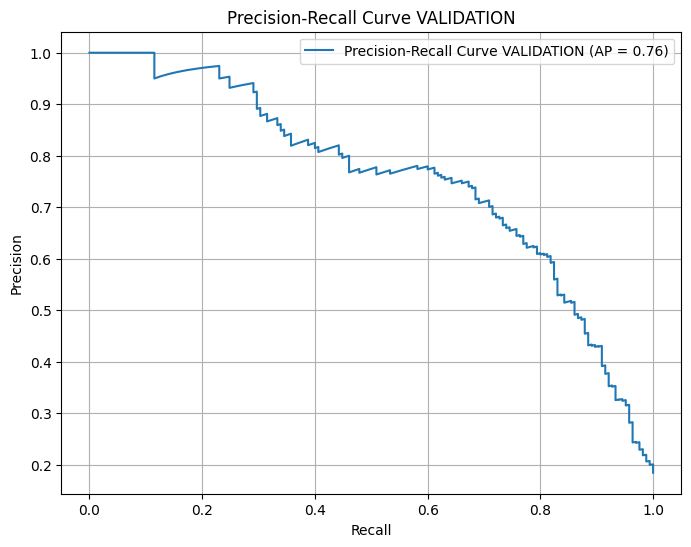

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Obtener las probabilidades de la clase positiva
y_scores = model_tuning.predict_proba(X_val)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_val, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve VALIDATION (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve VALIDATION')
plt.legend(loc='best')
plt.grid()
plt.show()

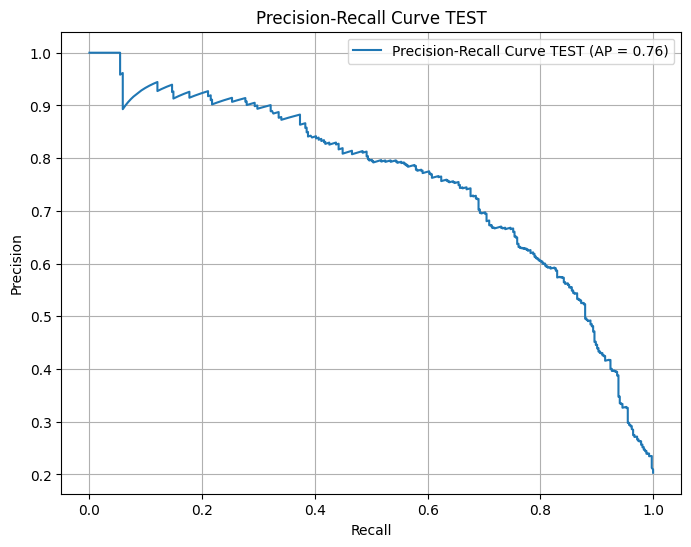

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Obtener las probabilidades de la clase positiva
y_scores = C.predict_proba(X_test)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_test, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve TEST (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve TEST')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
pred_ptest = model_tuning.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_ptest[:, 1])
auc_test = metrics.auc(fpr, tpr)
f1_test = metrics.f1_score(y_test, y_pred_test)
prcson_test = metrics.precision_score(y_test, y_pred_test)

print(f"auc_test:{auc_test}")
print(f"f1_score_test:{f1_test}")
print(f"precision_test:{prcson_test}")
print(classification_report(y_test, y_pred_test))

conf_matrix_test = metrics.confusion_matrix(y_test, y_pred_test)
conf_matrix_test

auc_test:0.904001517108824
f1_score_test:0.6648501362397821
precision_test:0.7845659163987139
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1658
           1       0.78      0.58      0.66       423

    accuracy                           0.88      2081
   macro avg       0.84      0.77      0.80      2081
weighted avg       0.88      0.88      0.87      2081



array([[1591,   67],
       [ 179,  244]])

In [ ]:
pred_pval = model_tuning.predict_proba(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred_pval[:, 1])
auc_val = metrics.auc(fpr, tpr)
f1_val = metrics.f1_score(y_val, y_pred)
prcson_val = metrics.precision_score(y_val, y_pred)

print(f"auc_val:{auc_val}")
print(f"f1_score_val:{f1_val}")
print(f"precision_val:{prcson_val}")
print(classification_report(y_val, y_pred))

conf_matrix_val = metrics.confusion_matrix(y_val, y_pred)
conf_matrix_val

auc_val:0.9057942057942058
f1_score_val:0.6864686468646866
precision_val:0.7536231884057971
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       728
           1       0.75      0.63      0.69       165

    accuracy                           0.89       893
   macro avg       0.84      0.79      0.81       893
weighted avg       0.89      0.89      0.89       893



array([[694,  34],
       [ 61, 104]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fb3d1e1c-84f2-4bf1-ad35-6e38fa357354' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>